# C23-PR588 SGD/IDR DNN MODEL 

Import necessary libraries

In [22]:
%run helper_functions_and_libraries.py
logging.set_verbosity(logging.ERROR)

Begin by looking at the structure of the csv that contains the data:

In [23]:
CURRENCIES_CSV = './currency_data_10_years.csv'

# Create dataframe by using datas from csv file
currencies_df = pd.read_csv(CURRENCIES_CSV)

# Create new dataframe containing ONLY needed data for the model
sgd_idr_df = currencies_df[['date', 'SGD']]

# Displaying the first and last 5 row of data to understand the contents of the data
display(sgd_idr_df.head())
display(sgd_idr_df.tail())

,date,SGD
0,2013-05-01,7884.025975
1,2013-05-02,7878.089194
2,2013-05-03,7879.444847
3,2013-05-04,7886.016560
4,2013-05-05,7859.545641


,date,SGD
3648,2023-04-27,11006.712235
3649,2023-04-28,10987.310199
3650,2023-04-29,10988.126246
3651,2023-04-30,10987.942405
3652,2023-05-01,10979.160369


Each data point is composed of the date and the recorded exchange rate from SGD to IDR

## Parsing the raw data
Read the data from the csv file and Creating global (G) dataclass

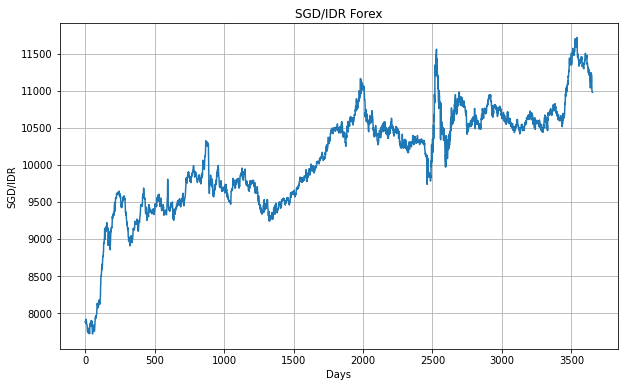

In [24]:
# Test your function and save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    
    DATAFRAME = sgd_idr_df
    times, values = parse_data_from_df(DATAFRAME, 'SGD')
    TIME = times
    SERIES = values
    SPLIT_TIME = 3200
    WINDOW_SIZE = 30
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES, title="SGD/IDR Forex", xlabel="Days", ylabel="SGD/IDR")

## Processing the data

train_val_split and windowed_dataset functions taken from 'tensorflow-sequences-time-series-and-prediction' courses in Coursera

In [25]:
# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES, G.SPLIT_TIME)

In [26]:
# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosi

## Defining the model architecture

In [27]:
def create_model():
    
    # Build the model
    model = tf.keras.models.Sequential([
        
        tf.keras.layers.Dense(30, input_shape=[G.WINDOW_SIZE], activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1)

    ])

    return model

In [28]:
# Create and test model
model = create_model()

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,251
Trainable params: 1,251
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Get initial weights
init_weights = model.get_weights()

# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

## Adjusting the learning rate

In [30]:
def adjust_learning_rate(dataset, model_to_train):

    model = model_to_train

    # Set the learning rate scheduler
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
    
    # Select optimizer
    optimizer = tf.keras.optimizers.SGD(momentum=0.9)
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer)
    
    # Train the model
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

    return history

In [31]:
# Run the training with dynamic LR
history = adjust_learning_rate(train_set, model)

Epoch 1/100
100/100 [==============================] - 1s 4ms/step - loss: 7484.9424 - lr: 1.0000e-08
Epoch 2/100
100/100 [==============================] - 0s 3ms/step - loss: 640.2003 - lr: 1.1220e-08
Epoch 3/100
100/100 [==============================] - 0s 3ms/step - loss: 84.5266 - lr: 1.2589e-08
Epoch 4/100
100/100 [==============================] - 0s 3ms/step - loss: 84.0089 - lr: 1.4125e-08
Epoch 5/100
100/100 [==============================] - 0s 3ms/step - loss: 83.6263 - lr: 1.5849e-08
Epoch 6/100
100/100 [==============================] - 0s 3ms/step - loss: 84.5955 - lr: 1.7783e-08
Epoch 7/100
100/100 [==============================] - 0s 3ms/step - loss: 86.3756 - lr: 1.9953e-08
Epoch 8/100
100/100 [==============================] - 0s 3ms/step - loss: 83.9132 - lr: 2.2387e-08
Epoch 9/100
100/100 [==============================] - 0s 3ms/step - loss: 86.9382 - lr: 2.5119e-08
Epoch 10/100
100/100 [==============================] - 0s 3ms/step - loss: 85.5583 - lr: 2.8184e

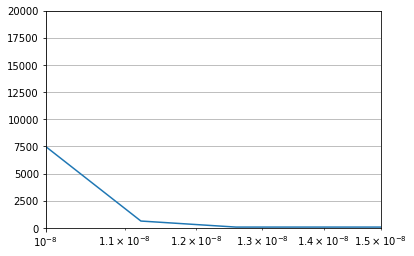

In [32]:
# Plot the loss in log scale
plt.semilogx(history.history["lr"], history.history["loss"])

# Set the plot boundaries
plt.axis([1e-8, 1.5e-8, 0, 20000])

# Set the grid
plt.grid(True)

In [33]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

## Compiling the model

In [34]:
def compile_model(dataset, model_to_train):

    model = model_to_train

    # Select optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
        
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])
        
    # Train the model
    history = model.fit(dataset, epochs=100)

    return history

In [35]:
history = compile_model(train_set, model)

Epoch 1/100
100/100 [==============================] - 1s 3ms/step - loss: 7484.0469 - mae: 7484.5469
Epoch 2/100
100/100 [==============================] - 0s 3ms/step - loss: 676.3310 - mae: 676.8298
Epoch 3/100
100/100 [==============================] - 0s 3ms/step - loss: 84.5241 - mae: 85.0222
Epoch 4/100
100/100 [==============================] - 0s 3ms/step - loss: 83.7811 - mae: 84.2795
Epoch 5/100
100/100 [==============================] - 0s 3ms/step - loss: 83.2130 - mae: 83.7117
Epoch 6/100
100/100 [==============================] - 0s 3ms/step - loss: 83.8328 - mae: 84.3310
Epoch 7/100
100/100 [==============================] - 0s 3ms/step - loss: 83.5247 - mae: 84.0235
Epoch 8/100
100/100 [==============================] - 0s 3ms/step - loss: 83.1408 - mae: 83.6388
Epoch 9/100
100/100 [==============================] - 0s 3ms/step - loss: 83.6647 - mae: 84.1627
Epoch 10/100
100/100 [==============================] - 0s 3ms/step - loss: 82.9659 - mae: 83.4648
Epoch 11/100


## Visualize MAE and loss

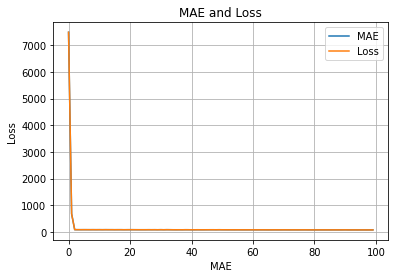

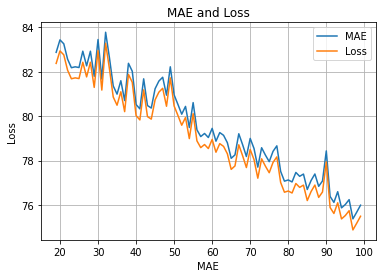

In [36]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    time=epochs, 
    series=(mae, loss), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    time=epochs_zoom, 
    series=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

## Evaluating the forecast

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
15/15 [==============================] - 0s 4ms/step
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the 

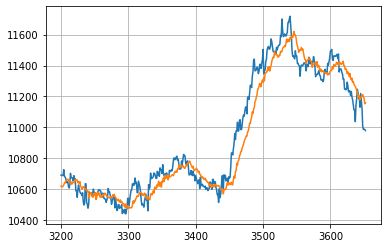

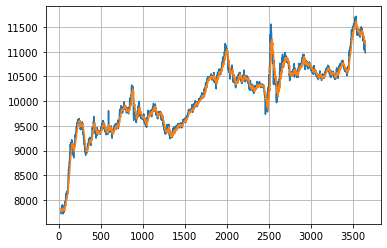

In [37]:
# Slice the forecast to get only the predictions for the validation set
dnn_forecast_valid_series = G.SERIES[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Compute the forecast for all the series
dnn_forecast_valid = model_forecast(model, dnn_forecast_valid_series, G.WINDOW_SIZE, G.BATCH_SIZE).squeeze()
dnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE, G.BATCH_SIZE).squeeze()

# Plot the forecast
plot_series(time_valid, (series_valid, dnn_forecast_valid))
plot_series(G.TIME[G.WINDOW_SIZE-1:], (G.SERIES[G.WINDOW_SIZE-1:], dnn_forecast))

In [38]:
compute_metrics(series_valid, dnn_forecast_valid)

{'mae': array([320.50497, 320.6462 , 320.6347 , 320.62704, 320.2211 , 320.94254,
        321.35144, 322.39523, 327.1247 , 327.15753, 325.6856 , 335.7277 ,
        340.54428, 331.99512, 320.20303, 321.8178 , 321.80127, 322.14282,
        324.51804, 320.67987, 322.70468, 322.56998, 349.57407, 350.54132,
        377.52658, 346.4896 , 332.04428, 344.0337 , 353.9464 , 359.32486,
        359.4235 , 368.77368, 357.42267, 401.17773, 422.1959 , 409.16602,
        329.53598, 329.5638 , 407.79575, 416.30542, 442.04642, 420.38107,
        354.26328, 358.57224, 358.52835, 359.69296, 370.60733, 359.51193,
        344.0999 , 355.60483, 360.32953, 360.8187 , 372.18176, 363.67004,
        360.0696 , 350.42432, 346.08496, 348.96045, 348.41284, 351.61157,
        367.3094 , 366.96838, 358.44147, 372.44394, 384.77975, 384.79895,
        389.60754, 406.13385, 393.1071 , 377.13644, 342.07632, 353.47714,
        353.4777 , 367.12814, 383.46878, 417.83905, 397.56708, 385.65326,
        373.19485, 373.2937 , 4

In [39]:
print(f'2 last Actual Price = {series_valid[-2:]}, Predicted Price = {dnn_forecast_valid[-2:]}')

2 last Actual Price = [[10987.942405]
 [10979.160369]], Predicted Price = [11153.05  11159.091]


## Future Predictions

In [40]:
into_future = 100

future_forecast = make_future_forecast(values=G.SERIES,
                                       model=model,
                                       into_future=into_future,
                                       window_size=G.WINDOW_SIZE)

1/1 [==============================] - 0s 21ms/step
Predicting on:
 [[11243.282401]
 [11248.308071]
 [11293.096935]
 [11265.897545]
 [11229.3888  ]
 [11236.343212]
 [11235.48918 ]
 [11206.583461]
 [11232.674909]
 [11197.497336]
 [11179.455376]
 [11145.289275]
 [11113.02285 ]
 [11111.358403]
 [11037.493068]
 [11144.088441]
 [11185.13609 ]
 [11246.659041]
 [11225.170434]
 [11187.171469]
 [11187.171598]
 [11130.554967]
 [11219.609397]
 [11167.954377]
 [11122.186126]
 [11006.712235]
 [10987.310199]
 [10988.126246]
 [10987.942405]
 [10979.160369]] -> Prediction: 11145.880859375

1/1 [==============================] - 0s 52ms/step
Predicting on:
 [11248.308071   11293.096935   11265.897545   11229.3888
 11236.343212   11235.48918    11206.583461   11232.674909
 11197.497336   11179.455376   11145.289275   11113.02285
 11111.358403   11037.493068   11144.088441   11185.13609
 11246.659041   11225.170434   11187.171469   11187.171598
 11130.554967   11219.609397   11167.954377   11122.186126
 

In [41]:
start_future = G.TIME[-1] + 1
future_time = np.arange(start_future, start_future + into_future)

# Insert last timestep/final price into next time steps and future forecasts so the plot connects
future_time = np.insert(future_time, 0, G.TIME[-1])
future_forecast = np.insert(future_forecast, 0, G.SERIES[-1])

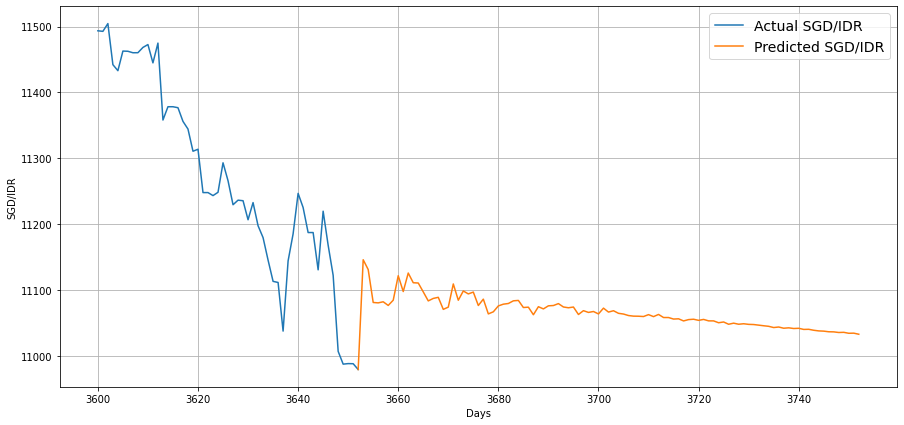

In [42]:
plt.figure(figsize=(15,7))
plot_future_forecast(G.TIME, G.SERIES, start=3600, format="-", label="Actual SGD/IDR", xlabel="Days", ylabel="SGD/IDR")
plot_future_forecast(future_time, future_forecast, format="-", label="Predicted SGD/IDR", xlabel="Days", ylabel="SGD/IDR")

### Model is unstable and mostly overfitted, the MAE is over 100 which make this model a bad model